## Inferential regression

Inferential linear regression is the process of building a linear-regression model based on data that is assumed to reflect reality, and using the model itself to infer to understand reality. Typically this takes the form of a null hypothesis test: assume some coefficient of the model is zero, choose alpha, collect the data, build the model, and determine if the p-value is sufficiently small to reject the assumption.

For this to be true, the p-value must represent the actual false-positive rate, so must be uniformly distributed between zero and one if the null hypothesis is true. That will be the case if a set of conditions is met, commonly referred to as the **assumptions of linear regression**.

This notebook examines the effect of violating some of these assumptions on the distribution of this p-value.

Note that that linear regression may still be done if these assumptions aren't met and may provide good predictions, but the p-values won't be uniformly distributed.

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy.special import expit, logit
%matplotlib inline

We're using kernel-density estimation (KDE) for visualization. It's a little ugly using a KDE on bounded data, so we're transforming the variables following http://thirdorderscientist.org/homoclinic-orbit/2013/10/24/kernel-density-estimation-for-random-variables-with-bounded-support-mdash-the-transformation-trick. An alternate approach (reflecting the kernels on the boundaries) could also be used.

First, a number of supporting functions to generate and visualize the results.

In [2]:
def bounded_kde(dataset):
    """return a gaussian kde function bounded (for now) between 0 and 1, in 1 dimension
    Note that it doesn't handle x=0 or x=1. It should get some limit."""
    kde = stats.gaussian_kde(logit(dataset))
    return lambda x: kde(logit(x))/(x*(1-x))

In [3]:
def get_nfeatures(xfunc):
    '''Figure out number of features from the function to generate x
    '''
    testx = xfunc(1)
    if len(testx.shape) != 2:
        raise ValueError('xfunc should return a 2D array')
    else:
        return testx.shape[1]

In [4]:
def sample_pvalues(xfunc, yfunc, npts=100, ntrials=10000):
    """
       xfunc :   function taking 1 argument (npts); returns a (npts, nfeatures) ndarray
       yfunc :   function taking 1 argument (x); returns corresponding y values
       npts :    number of points to get
       ntrials : number of p-values to calculate"""
    nfeatures = get_nfeatures(xfunc)

    pvalues = np.zeros((ntrials, nfeatures))
    for i in range(ntrials):
        x = xfunc(npts)
        y = yfunc(x)
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        pvalues[i] = results.pvalues[1:]
    return pvalues

In [5]:
def hist_pvalues(ax, pvalues, bins=50):
    ax.hist(pvalues, bins=bins, density=True, alpha=0.5, label='histogram of pvalues');
    ax.set_xlabel('p-value')
    ax.set_title(f'Distribution of p-values of $\\beta_1$ of linear regression')
    kde = bounded_kde(pvalues)
    # skip endpoints because it gives an error
    # (though it probably has a limit somewhere?)
    ps = np.linspace(0, 1, 200)[1:-1]
    ax.plot(ps, kde(ps), 'r', label='bounded kde')
    ax.plot([0,1], [1,1], 'k:', label='expected if p-value were FPR')
    ax.legend()

In [6]:
def draw_func(ax, xfunc, yfunc, feature, npts, label=None):
    """Generate a single sample and plot it on an axis
        ax      : matplotlib axis on which to plot the data
        xfunc   : function to generate x values of a specified number of points
        yfunc   : function to generate y values from an array of x values
        feature : number of feature to plot
        npts    : number of points to generate
        label   : label to use for points"""
    x = xfunc(npts)
    y = yfunc(x)
    ax.plot(x[:, feature], y, '.', label=label)

In [7]:
def sample_and_show(xfunc, yfunc, npts=100, ntrials=1000):
    """Generate
    """
    nfeatures = get_nfeatures(xfunc)

    fig, axs = plt.subplots(nfeatures, 2, figsize=(15,5*nfeatures))
    # because subplots returns a 1-d array if one argument is 1
    axs = axs.reshape(-1, 2)

    pvalues = sample_pvalues(xfunc,
                        yfunc,
                        npts=npts,
                        ntrials=ntrials)
    
    for i in range(nfeatures):
        for j in range(3):
            draw_func(axs[i, 0],
                      xfunc,
                      yfunc,
                      i,
                      npts,
                      label=f'sample {j}')
        axs[i, 0].legend()
   
        hist_pvalues(axs[i, 1], pvalues[:, i])

## Assumptions met

First, we assume that all the assumptions are met. Since we're looking for the distribution of the p-values under the null hypothesis, we assume $b_1 = 0$.

In [8]:
beta0 = 1
beta1 = 0
xfunc = lambda npts: stats.uniform(0, 10).rvs((npts, 1))
yfunc = lambda x: beta0 + beta1 * x[:, 0] + stats.norm(0, 1).rvs(len(x))

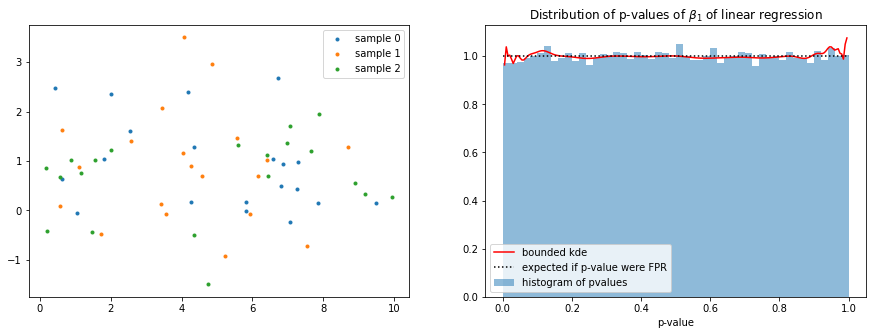

In [9]:
sample_and_show(xfunc, yfunc, 20, 100000)

The p-value (calculated here by `statsmodels`) is the probability that, under the given null hypothesis (that the `y` values are normally distributed and independent of `x`), the beta coefficient would be as greater than or equal to what we actually saw. As we see, this is uniformly distributed...

We're going to imagine a bunch of other scenarios in which the expected value of $\beta_1$ is still 1, but the data are generated in some other way that violate the assumptions of inferential linear regression.

In all of these cases the null

What this graph means is that the distribution of p-values is uniform, so that under this hypothesis

## Non-normal errors

Let's try with uniform rather than normal errors.

In [10]:
xfunc = lambda npts: stats.uniform(0, 10).rvs((npts, 1))
yfunc = lambda x: stats.uniform(0, 1).rvs(len(x))

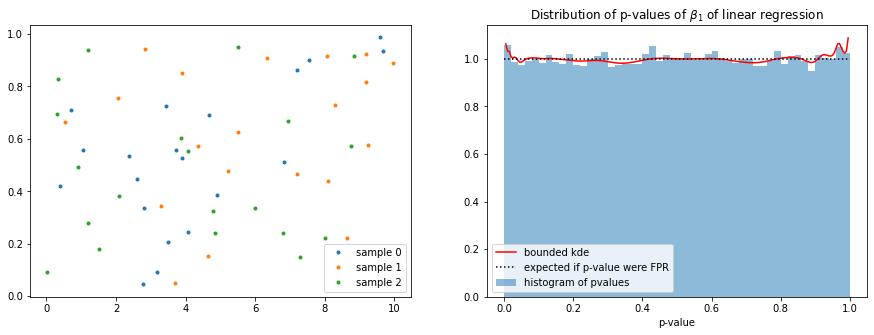

In [11]:
sample_and_show(xfunc, yfunc, 20, 100000)

Maybe something skewed and leptokurtic, like the exponential distribution?

In [12]:
xfunc = lambda npts: stats.uniform(0, 10).rvs((npts, 1))
yfunc = lambda x: stats.expon(0, 1).rvs(len(x))

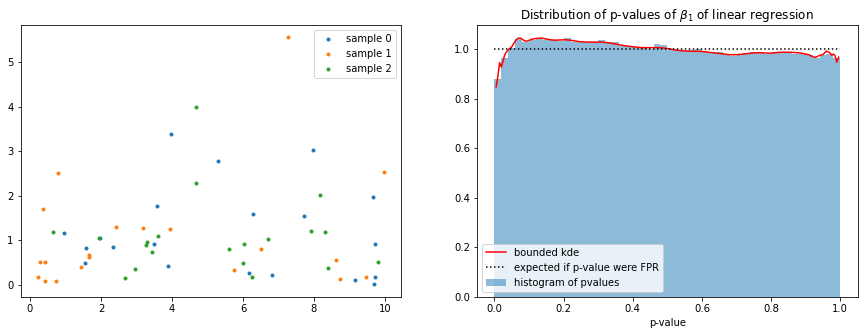

In [13]:
sample_and_show(xfunc, yfunc, 20, 1000000)

That's not too bad. How about a crazy distribution?

In [14]:
xfunc = lambda npts: stats.uniform(0, 10).rvs((npts, 1))
yfunc = lambda x: stats.cauchy(0, 1).rvs(len(x))

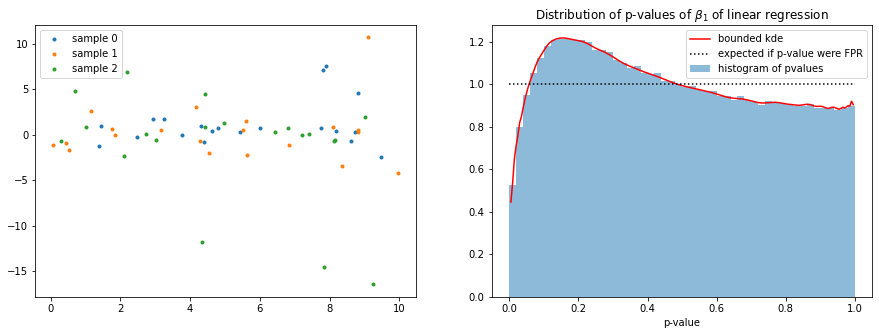

In [15]:
sample_and_show(xfunc, yfunc, 20, 1000000)

Clearly that won't work.

## Random walk

What if we violate independence? A pretty extreme example is a random walk.

In [16]:
xfunc = lambda npts: np.linspace(0, 1, npts)[:, None]
yfunc =  lambda x: stats.norm(0, 1).rvs(len(x)).cumsum()

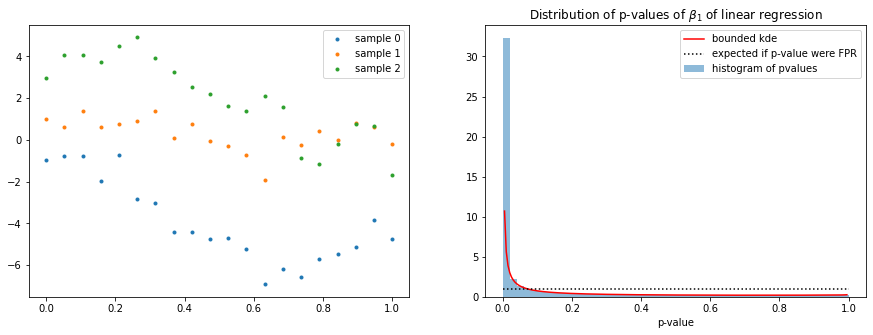

In [17]:
sample_and_show(xfunc, yfunc, 20, 100000)

Whoa. So random walk is bad.

Let's try a simple MA sequence.

In [18]:
xfunc = lambda npts: np.linspace(0, 1, npts)[:, None]
def yfunc(x):
    y = stats.norm(0, 1).rvs(len(x) + 1)
    return y[1:] +  1 * y[:-1]

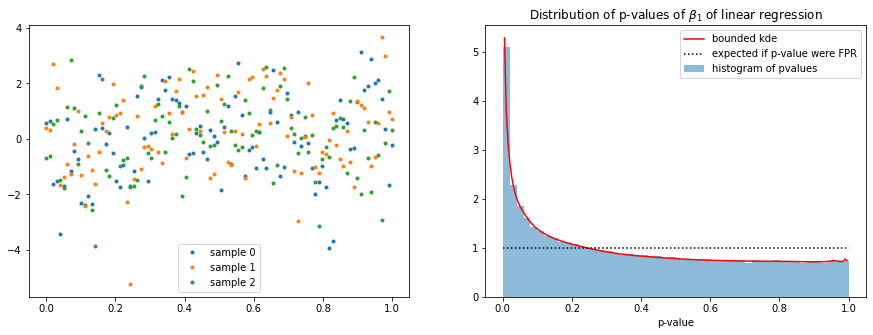

In [19]:
sample_and_show(xfunc, yfunc, 100, 100000)

## Heteroskedacity

In [20]:
xfunc = lambda npts: np.linspace(0, 1, npts)[:, None]
yfunc = lambda x: stats.norm(0, x[:, 0]).rvs(len(x))
#yfunc = lambda x: stats.norm(0, x[:, 0] - x[:, 0]**2).rvs(len(x))
#yfunc = lambda x: stats.norm(0, 0.25 - x[:, 0] + x[:, 0]**2).rvs(len(x))

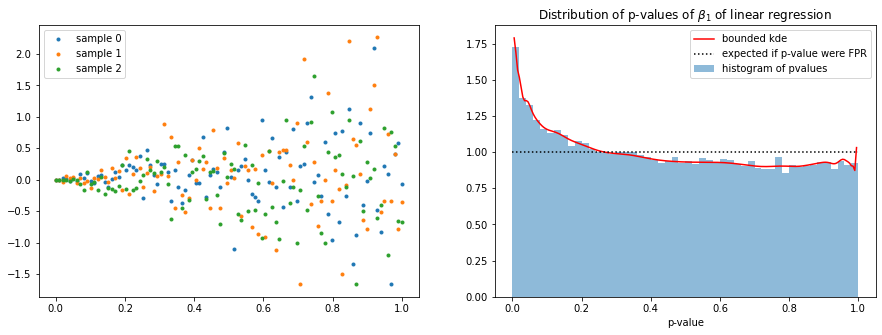

In [21]:
sample_and_show(xfunc, yfunc, 100, 100000)

## Non-linear

Here we add a quadratic term. Note that the it doesn't introduce an overall trend; we still expect the $\beta_1$ to be equal to 0.

In [22]:
xfunc = lambda npts: np.linspace(-1, 1, npts)[:, None]
yfunc = lambda x: x[:, 0]**2 + stats.norm(0, .3).rvs(len(x))

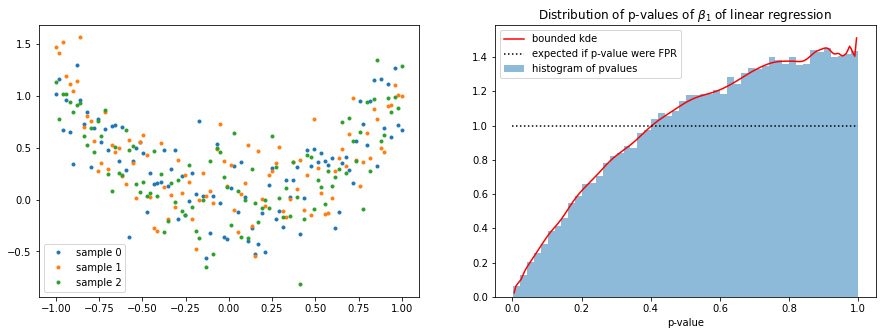

In [23]:
sample_and_show(xfunc, yfunc, 100, 100000)

## Correlated variable

In [24]:
npts = 20
xfunc = lambda npts: stats.uniform(0, 10).rvs((npts, 2))
def yfunc(x):
    x2 = x[:, 0] + stats.norm(0, 1).rvs(len(x))
    return beta0 + 0.1 * x2 + stats.norm(0, 1).rvs(len(x))

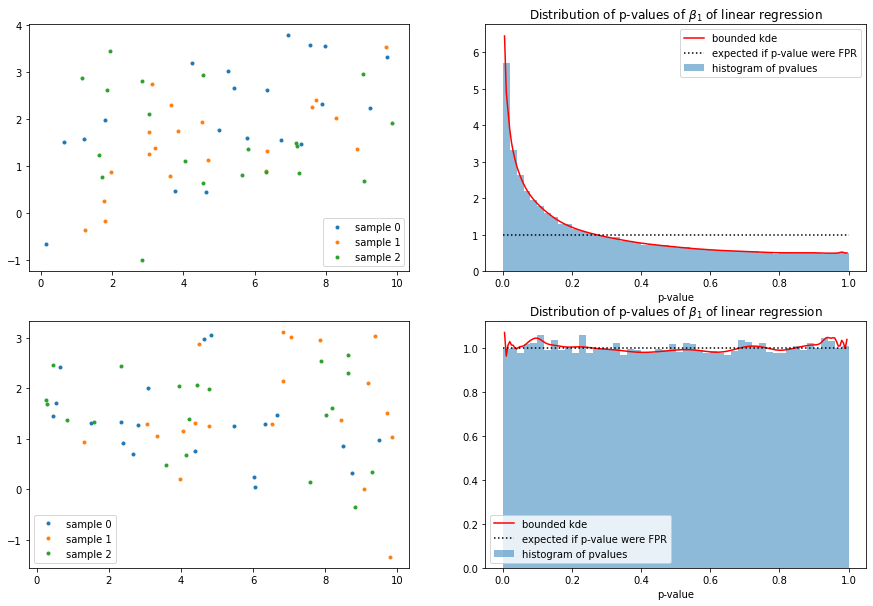

In [25]:
sample_and_show(xfunc, yfunc, 20, 100000)

## Multiple features
First, let's have them independent, and neither affect the `y`.

In [26]:
npts = 20
def xfunc(npts):
    return stats.norm(0, 10).rvs((npts, 2))

def yfunc(x):
    return stats.norm(0, 1).rvs(len(x))

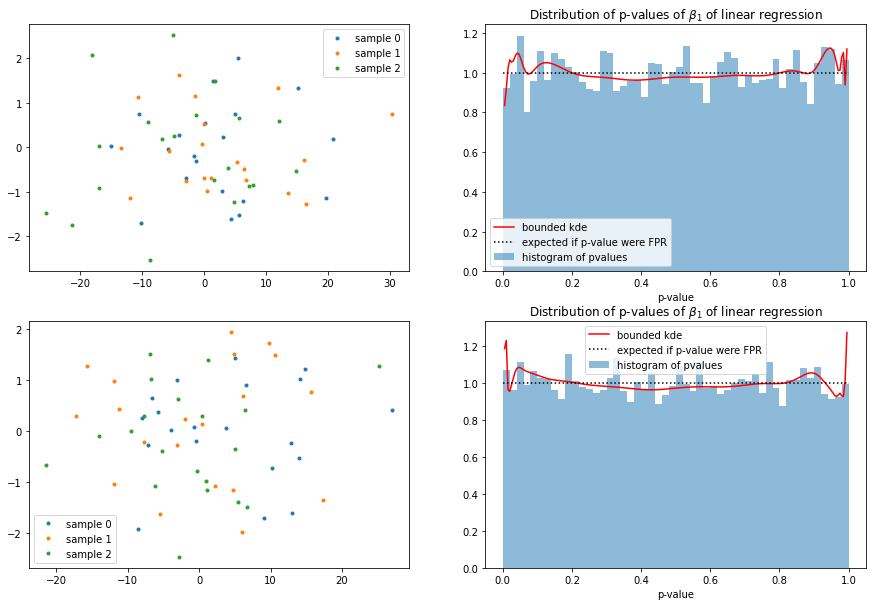

In [27]:
sample_and_show(xfunc, yfunc, 20, 10000)

Here we'll keep them independent but have one affect the result. In this case we don't expect the 2nd to have uniformly distributed p-values.

In [28]:
npts = 20
def xfunc(npts):
    return stats.norm(0, 10).rvs((npts, 2))

def yfunc(x):
    return stats.norm(0, 1).rvs(len(x)) + 0.1 * x[:, 1]

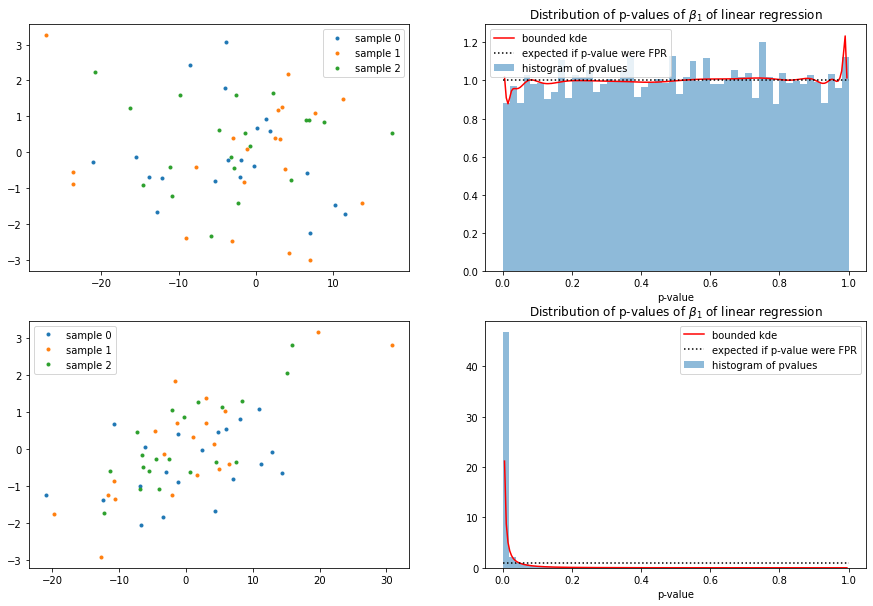

In [29]:
sample_and_show(xfunc, yfunc, 20, 10000)

And now we correlate them. First with the neither affecting `y`.

In [30]:
npts = 20
def xfunc(npts):
    x = stats.norm(0, 10).rvs((npts, 2))
    return x + 0.5 * x[:, ::-1]

def yfunc(x):
    return stats.norm(0, 1).rvs(len(x))

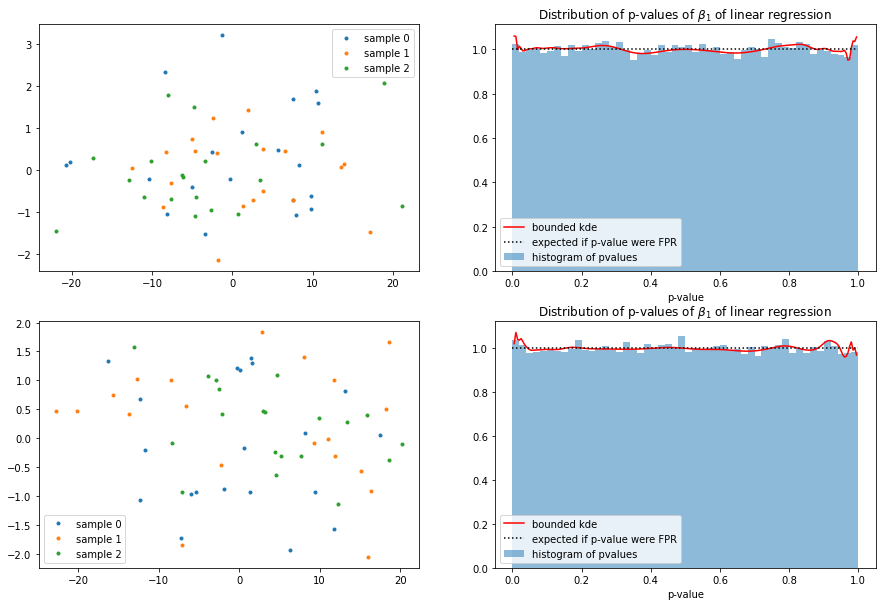

In [31]:
sample_and_show(xfunc, yfunc, 20, 100000)

Huh.

And finally, dependent with one affecting the result.

In [32]:
npts = 20
def xfunc(npts):
    x = stats.norm(0, 10).rvs((npts, 2))
    return x + 0.5 * x[:, ::-1]

def yfunc(x):
    return stats.norm(0, 1).rvs(len(x)) + 0.1 * x[:, 1]

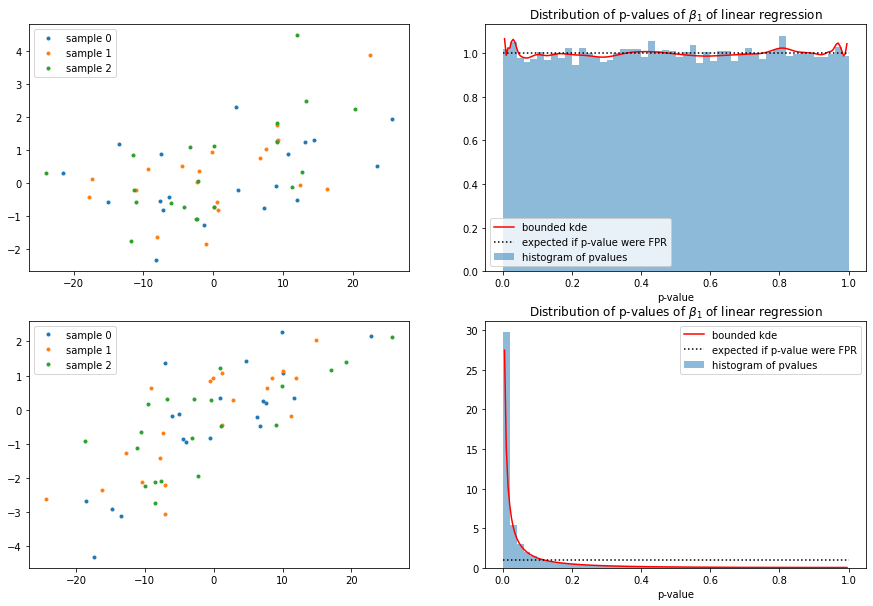

In [33]:
sample_and_show(xfunc, yfunc, 20, 100000)